In [1]:
# %matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import cv2

plt.style.use('seaborn-pastel')

from IPython.display import Image
from IPython.display import HTML

tf.__version__

'2.0.0'

In [38]:
def dense(size, activation):
    return tf.keras.layers.Dense(
        size,
        activation=activation,
        kernel_initializer=tf.random_normal_initializer(0, 1),
        bias_initializer=tf.random_normal_initializer(0, 1)
    )

class CPPNUV:
    def __init__(self, width, depth, mirror=False):
        self.layers = []
        self.mirror = mirror
        for i in range(depth):
            self.layers.append(dense(
                width, tf.sin if i == 0 else tf.sigmoid
            ))

        # output uv map
        self.layers.append(dense(2, tf.sigmoid))

    def generate_input_mesh(self, size):
        w, h = size
        ar = w / h
        x = np.linspace(-ar / 2, ar / 2, w)
        y = np.linspace(-0.5, 0.5, h)
        
        if self.mirror:
            x = np.abs(x)
            y = np.abs(y)
        
        xx, yy = np.meshgrid(x, y)
        mesh = np.stack((xx.reshape(-1), yy.reshape(-1)), axis=-1)

        return mesh

    def generate(self, z, im_size=(128, 128)):
        mesh = self.generate_input_mesh(im_size)
        # Add z to input
        result = np.concatenate((np.tile(z, (mesh.shape[0], 1)), mesh), axis=-1)
        result = np.float32(result)

        for d in self.layers:
            result = d(result)

        img = result.numpy().reshape(*im_size[::-1], -1)
        return img

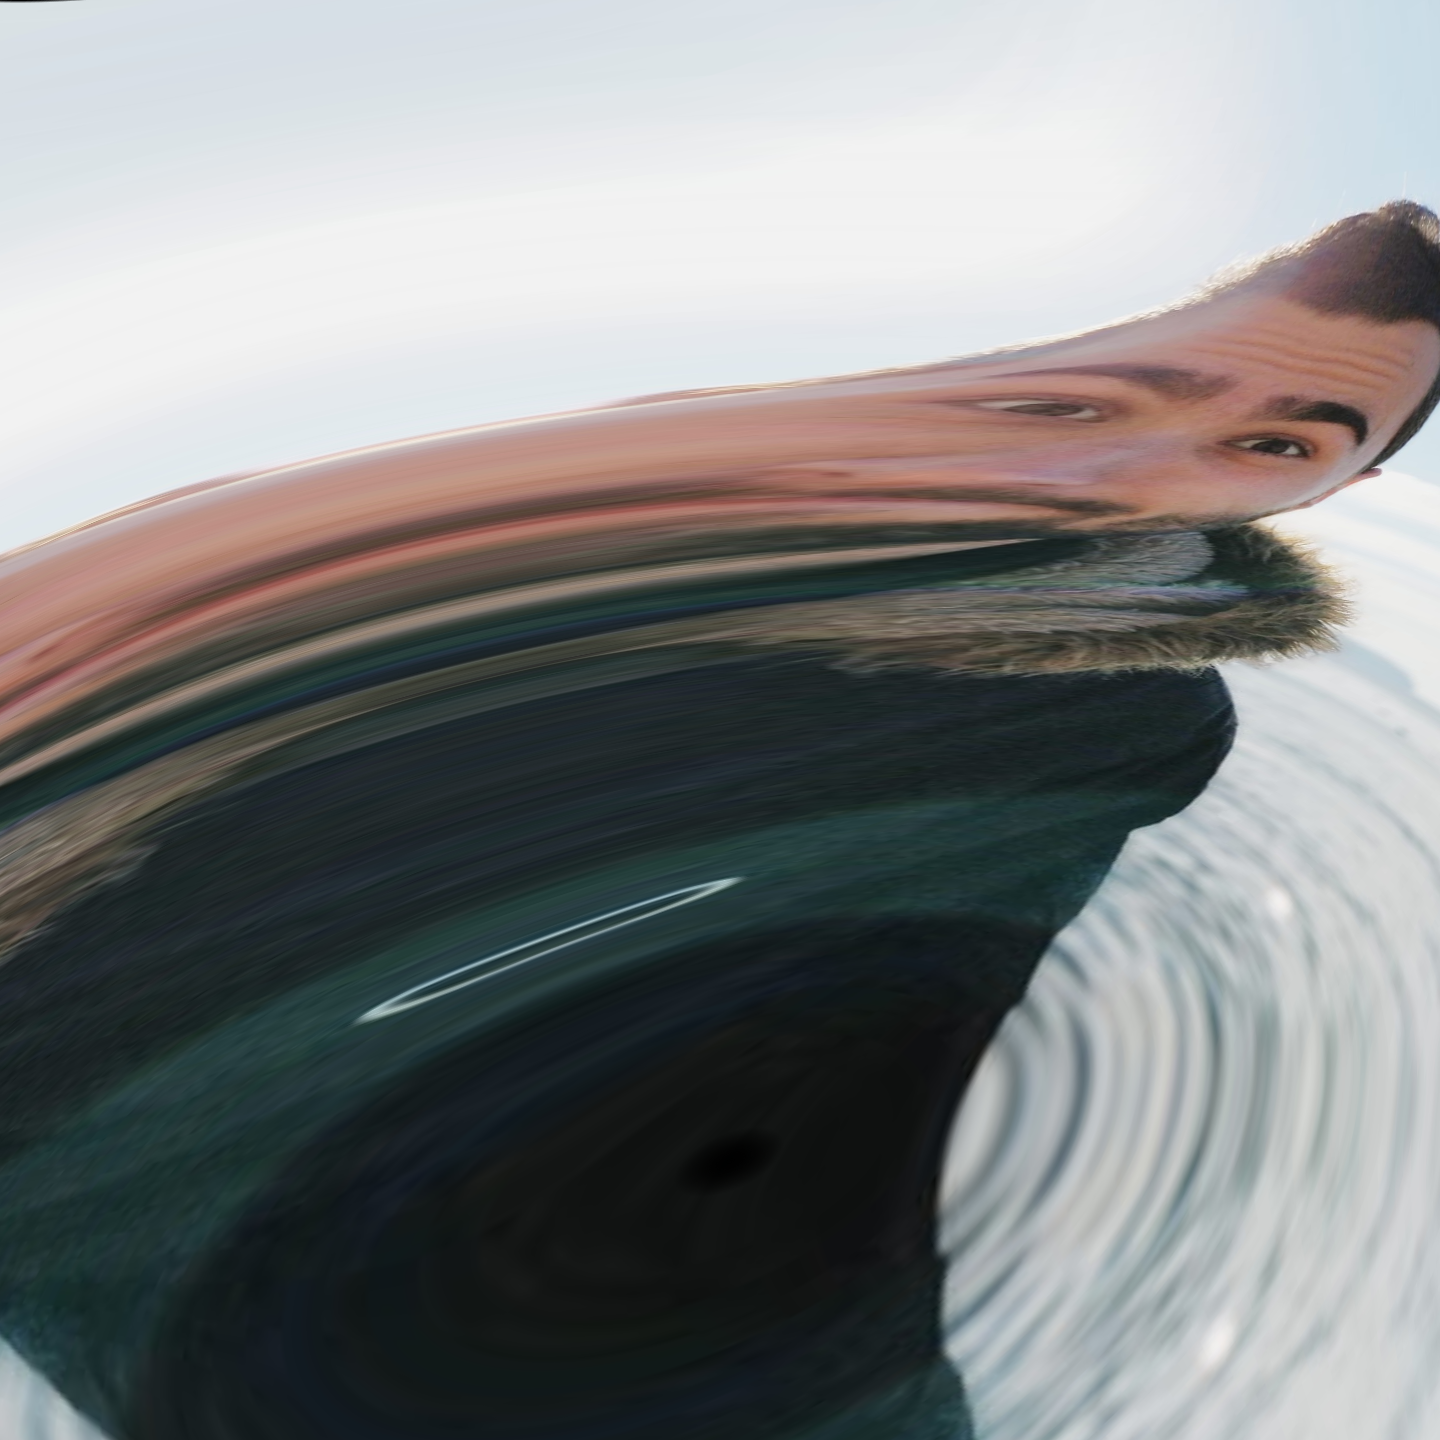

In [44]:
im = cv2.imread('avatar.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

uv = CPPNUV(8, 4, mirror=False).generate(1, im_size=(im.shape[0], im.shape[1]))
xx = uv[:, :, 0]
yy = uv[:, :, 1]

norm_xx = (xx - np.min(xx)) / (np.max(xx) - np.min(xx))
norm_yy = (yy - np.min(yy)) / (np.max(yy) - np.min(yy))


out = cv2.remap(im, norm_xx * im.shape[0], norm_yy * im.shape[1], cv2.INTER_AREA)

plt.imsave('test.png', out, format='png', cmap='Greys')
Image(filename='test.png', width=500)

In [6]:
def make_sampler(img_path, ppn_ctor, cols, rows):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # Save the networks
    cppns = []
    for r in range(rows):
        cppns.append([])
        for c in range(cols):
            cppns[-1].append(ppn_ctor())

    # Sample from the networks
    def sampler(z, w, h):
        rows_of_images = []
        for r in range(rows):
            row_of_images = []
            for c in range(cols):
                uv = cppns[r][c].generate(z, im_size=(w // cols, h // rows))
                xx = uv[:, :, 0]
                yy = uv[:, :, 1]

                norm_xx = (xx - np.min(xx)) / (np.max(xx) - np.min(xx))
                norm_yy = (yy - np.min(yy)) / (np.max(yy) - np.min(yy))


                out = cv2.remap(im, norm_xx * im.shape[0], norm_yy * im.shape[1], cv2.INTER_AREA)
                row_of_images.append(out)

            row = np.concatenate(row_of_images, axis=1)
            rows_of_images.append(row)

        return np.concatenate(rows_of_images, axis=0)

    return sampler

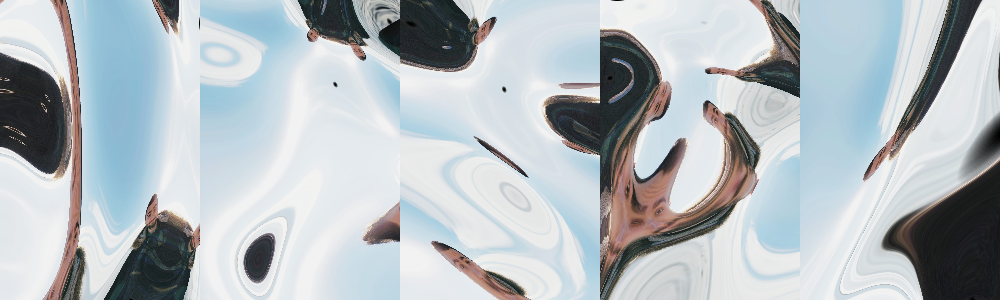

In [7]:
imgs = make_sampler(
    'avatar.jpg',
    lambda: CPPNUV(8, 4, mirror=False),
    cols=5,
    rows=1,
)(z=1, w=1000, h=300)
plt.imsave('temp.png', imgs)
Image(filename='temp.png')

In [28]:
def make_anim(img_path, ppn_ctor, cols, rows, duration=5, W=1000, H=1000):
    sampler = make_sampler(img_path, ppn_ctor, cols, rows)
    z_start = np.random.normal(0, 1, size=32)
    z_end = z_start + np.random.normal(0, 0.2, size=32)

    img = sampler(z_start, W, H)

    fig, ax = plt.subplots()
    ax.axis('off')

    l = ax.imshow(img, aspect='auto')
    plt.tight_layout()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    fig.set_size_inches(6, 6, forward=True)

    frames = 30 * duration # 30fps

    def animate(i):
        nonlocal z_start, z_end, frames
        lerp = np.sin(i / frames * np.pi)
        z = z_start * lerp + z_end * (1 - lerp)
        img = sampler(z, W, H)
        l.set_data(img)

    ani = FuncAnimation(fig, animate, frames=frames)

    return ani

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


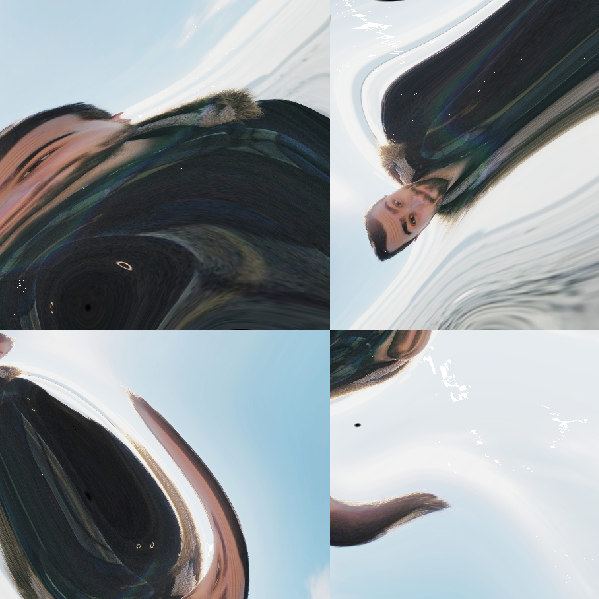

In [46]:
ani = make_anim('avatar.jpg', lambda: CPPNUV(30, 6, mirror=False), cols=2, rows=2, W=1000, H=1000, duration=5)

In [47]:
ani.save('lerping_uv_2.mp4', writer='imagemagick', fps=60)

In [72]:
ani = make_anim('scream.png', lambda: CPPNUV(30, 7, mirror=False), cols=1, rows=1, W=1000, H=1000, duration=5)

<IPython.core.display.Javascript object>

In [69]:
ani.save('scream_lerping_uv.mp4', writer='imagemagick', fps=60)